<a href="https://colab.research.google.com/github/rabi320/Data-Science-Projects/blob/master/English/English_Written_characters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  English Written characters
![](https://www.researchgate.net/profile/Niranjan-S-K/publication/265317661/figure/fig1/AS:306759173459968@1450148494911/Sample-image-of-English-characters.png)

This notebook will be used to classify 3,410 images of handwritten characters in English. This is a classification dataset that can be used for Computer Vision tasks. It contains 62 classes with 55 images of each class. The 62 classes are 0-9, A-Z and a-z.

In [54]:
# extract all files
import zipfile
zp = True
if zp:
    with zipfile.ZipFile("English Handwritten Characters.zip","r") as zip_ref:
        zip_ref.extractall("English Handwritten Characters")

In [55]:
import pandas as pd
df = pd.read_csv("English Handwritten Characters/english.csv")
df.sample(2)

,image,label
104,Img/img002-050.png,1
390,Img/img008-006.png,7


In [56]:
original = df.label.unique().tolist() #original labels
replace = list(range(len(original))) #encode the labels

labels = dict(zip(original,replace)) #make a dictionary of labels


save = True
if save:
  df.replace(to_replace = original, value = replace, inplace = True)
  df.to_csv("English Handwritten Characters/english.csv")

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3410 entries, 0 to 3409
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   3410 non-null   object
 1   label   3410 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 53.4+ KB


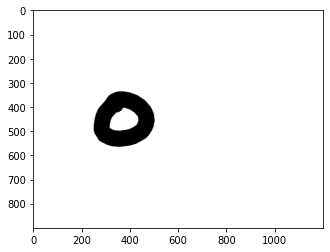

In [58]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as imread
random_image = df.sample()["image"].values[0]# get the image name
img=plt.imread(f"English Handwritten Characters/{random_image}")
plt.imshow(img)
plt.show()

In [59]:
img.shape

(900, 1200, 3)

In [60]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode



In [61]:
class EnglishWrittencharacters(Dataset):
    """English Written characters."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.English_Written_characters = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.English_Written_characters)

    def __getitem__(self, idx):

        img_name = os.path.join(self.root_dir,self.English_Written_characters["image"][idx])
                                
        image = io.imread(img_name)
        y_label = self.English_Written_characters["label"][idx]
        if self.transform:
            image = self.transform(image)

        return image, y_label

In [62]:
English_dataset = EnglishWrittencharacters(csv_file='English Handwritten Characters/english.csv',root_dir='English Handwritten Characters',transform = transforms.ToTensor())
                                    

f"the data has {English_dataset.__len__()} images"

'the data has 3410 images'

In [63]:
train_size = int(English_dataset.__len__()*0.7)
test_size = int(English_dataset.__len__() - train_size)
train, test = torch.utils.data.random_split(English_dataset, [train_size,test_size])

print(f"train size: {train.__len__()}\ntest size: {test.__len__()}")

train size: 2387
test size: 1023


In [64]:
trainloader = torch.utils.data.DataLoader(train, batch_size=7, shuffle=True)
testloader = torch.utils.data.DataLoader(test, batch_size=7, shuffle=False)

In [65]:
import torch.nn as nn
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 16, 5)
        self.fc1 = nn.Linear(222*297*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 62) #62 classes (0-9.a-z,A-Z)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)

In [66]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [67]:
len(labels)

62

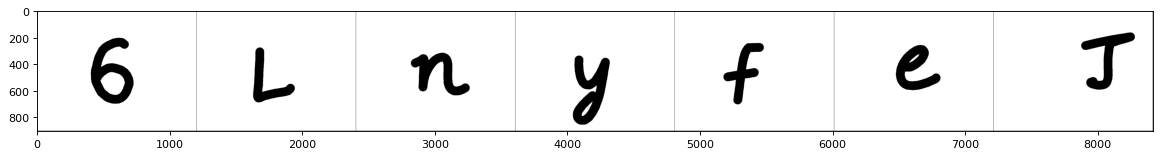

['6', 'L', 'n', 'y', 'f', 'e', 'J']


In [68]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# functions to show an image
def imshow(img):    
    plt.figure(figsize=(18, 16), dpi=80)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, targets = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))


# function to return key for any value
def get_key(val):
    for key, value in labels.items():
         if val == value:
             return key
 
    return "key doesn't exist"
print([get_key(target) for target in targets.numpy().tolist()])

In [70]:
#random data for testing the net
x = torch.rand((10,3,900,1200),device = device)
print(net(x).size())

torch.Size([10, 62])


In [71]:

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        #inputs = inputs.permute(0,3,2,1)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 50 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

print('Finished Training')

[1,    50] loss: 4.136
[1,   100] loss: 4.131
[1,   200] loss: 4.127
[1,   300] loss: 4.128
[2,    50] loss: 4.121
[2,   100] loss: 4.117
[2,   150] loss: 4.102
[2,   200] loss: 4.094
[2,   250] loss: 4.079
[2,   300] loss: 4.038
Finished Training


In [77]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        # calculate outputs by running images through the network 
        outputs = net(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print('Accuracy of the network on the 1023 test images: %.3f %%' % (
    100 * correct / total))

Accuracy of the network on the 1023 test images: 5.376 %
